In [38]:
import os 
#This module provides a portable way of using operating system dependent functionality.
import sys
#This module provides access to some variables used or maintained by the interpreter and 
#to functions that interact strongly with the interpreter
sys.path.append('..')

import lzma
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se
se.set_style('white')
se.set_context('poster')

import pyquery
from ipywidgets import FloatProgress
from IPython.display import display

from config import settings
import utils
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import DBSCAN
import numpy as np


In [39]:
cases_format="json"
#else "xml" 
#cases_format="xml"
compressed_file = utils.get_cases_from_bulk(jurisdiction="New Mexico", data_format=cases_format)

downloading New Mexico-20200302-text.zip into ../data dir


66568it [00:54, 1211.09it/s]

extracting New Mexico-20200302-text.zip into ../data dir
Done.


In [40]:
#a list to hold the cases we're sampling
cases = []

#decompress the file line by line
with lzma.open(compressed_file) as infile:
    for line in infile:
        #decode the file into a convenient format
        record = json.loads(str(line, 'utf-8'))
        #if the decision date on the case matches one we're interested in, add to our list
        cases.append(record)

print("Selected jurisdiction: New Mexico")
print("Number of Cases: ", len(cases))

Selected jurisdiction: New Mexico
Number of Cases:  18338


In [41]:
def parse_json(case):
    feat_dict = {}
    feat_dict["case_id"] = case['id']
    feat_dict["case_url"] = case['url']
    feat_dict["case_name"] = case['name']
    feat_dict["case_name_abbreviation"] = case['name_abbreviation']
    feat_dict["date"] = case['decision_date']
    feat_dict["citations"] = [citation for citation in case['citations'] if citation['type'] == 'official'][0]
    #feat_dict["volume"] = case['volume']
    feat_dict["court"] = case['court']['name']
    feat_dict["jurisdiction"] = case['jurisdiction']#['name_long']
    #feat_dict["name"] = case['jurisdiction']['name']
    feat_dict["judges"]=case["casebody"]["data"]["judges"]
    feat_dict["attorneys"]=case["casebody"]["data"]["attorneys"]
    feat_dict["author"]=case["casebody"]["data"]["opinions"][0]["author"]
    
    #Main text: opinions
    feat_dict["opinion"]=case["casebody"]["data"]["opinions"][0]["text"]
    
    return feat_dict

In [42]:
#Add progress bar
bar = FloatProgress(min=0, max=len(cases))
display(bar)

#For each file, parse with parse_xml() and add to list of parsed files
parsed_files = []
for case in cases:
    doc = parse_json(case) #json
    #doc = ET_parse_xml(case) #xml
    parsed_files.append(doc)
    bar.value += 1

FloatProgress(value=0.0, max=18338.0)

# Author

In [43]:
raw_df = pd.DataFrame(parsed_files)

In [44]:
authors_cases_dict = {}


for index, row in raw_df.iterrows():
    case_id = row['case_id']
    author = row['author']
    date = pd.to_datetime(row['date']) 

    if author and author[0].isalpha() :
        # Split names of judges separated by ",".
        author = [a.strip() for a in author.split(',')][0]
        author = [a.strip() for a in author.split('.')][0]
        author = [a.strip() for a in author.split(';')][0]
        author = author.upper() 

        if author in authors_cases_dict:
            authors_cases_dict[author].append((date.year, case_id))
        else:
            authors_cases_dict[author] = [(date.year, case_id)]

count = 0
for author, case_id in authors_cases_dict.items():
    print(f"Number of Cases: {len(case_id)}")
    print(f"Author: {author}")
    print(f"Case IDs: {case_id}")
    print()
    count = count + 1
    if count == 3:
        break

Number of Cases: 312
Author: MINZNER
Case IDs: [(1997, 17491), (1997, 142194), (1997, 17275), (1997, 17773), (1998, 18391), (1997, 18126), (1997, 18555), (1997, 17424), (1997, 18448), (1998, 834248), (1998, 834296), (1997, 17149), (1996, 322306), (1998, 827451), (1998, 827374), (1998, 834293), (1999, 257758), (2000, 1217180), (1996, 322293), (1997, 142281), (1998, 827383), (1999, 827421), (1998, 827403), (1999, 257625), (1999, 257751), (1998, 834335), (1998, 834166), (1998, 834182), (1998, 834219), (1998, 834357), (1999, 106570), (1999, 257693), (1999, 106526), (1999, 106506), (1999, 106492), (2000, 106498), (2000, 1217162), (2000, 1217163), (1999, 106574), (1997, 142211), (1997, 142269), (1997, 142249), (1997, 142214), (2000, 1217109), (2000, 1217106), (2000, 1217174), (1996, 322308), (1996, 322263), (1996, 322254), (1996, 322273), (1996, 322314), (1996, 322344), (1997, 18767), (2004, 1224598), (2005, 929183), (2005, 929161), (2002, 260756), (2002, 260735), (2001, 352473), (2001, 3524

In [45]:
total_clusters = len(authors_cases_dict)
print(f"Total Clusters: {total_clusters}")

Total Clusters: 455


In [46]:
# We ignore clusters with only one element
count = 0
for author, case_ids in authors_cases_dict.items():
    num_cases = len(case_ids)
    if num_cases > 1:  # Only print if the cluster has more than one case
        print(f"Number of Cases: {num_cases}")
        print(f"Author: {author}")
        print(f"Case IDs: {case_ids}")
        print()
        count = count + 1
        if count == 3:
            break
        

Number of Cases: 312
Author: MINZNER
Case IDs: [(1997, 17491), (1997, 142194), (1997, 17275), (1997, 17773), (1998, 18391), (1997, 18126), (1997, 18555), (1997, 17424), (1997, 18448), (1998, 834248), (1998, 834296), (1997, 17149), (1996, 322306), (1998, 827451), (1998, 827374), (1998, 834293), (1999, 257758), (2000, 1217180), (1996, 322293), (1997, 142281), (1998, 827383), (1999, 827421), (1998, 827403), (1999, 257625), (1999, 257751), (1998, 834335), (1998, 834166), (1998, 834182), (1998, 834219), (1998, 834357), (1999, 106570), (1999, 257693), (1999, 106526), (1999, 106506), (1999, 106492), (2000, 106498), (2000, 1217162), (2000, 1217163), (1999, 106574), (1997, 142211), (1997, 142269), (1997, 142249), (1997, 142214), (2000, 1217109), (2000, 1217106), (2000, 1217174), (1996, 322308), (1996, 322263), (1996, 322254), (1996, 322273), (1996, 322314), (1996, 322344), (1997, 18767), (2004, 1224598), (2005, 929183), (2005, 929161), (2002, 260756), (2002, 260735), (2001, 352473), (2001, 3524

In [47]:
# Count the total number of clusters (excluding clusters with one case)
total_clusters = sum(1 for case_ids in authors_cases_dict.values() if len(case_ids) > 1)
print(f"Total Clusters (excluding clusters with one case): {total_clusters}")

Total Clusters (excluding clusters with one case): 253


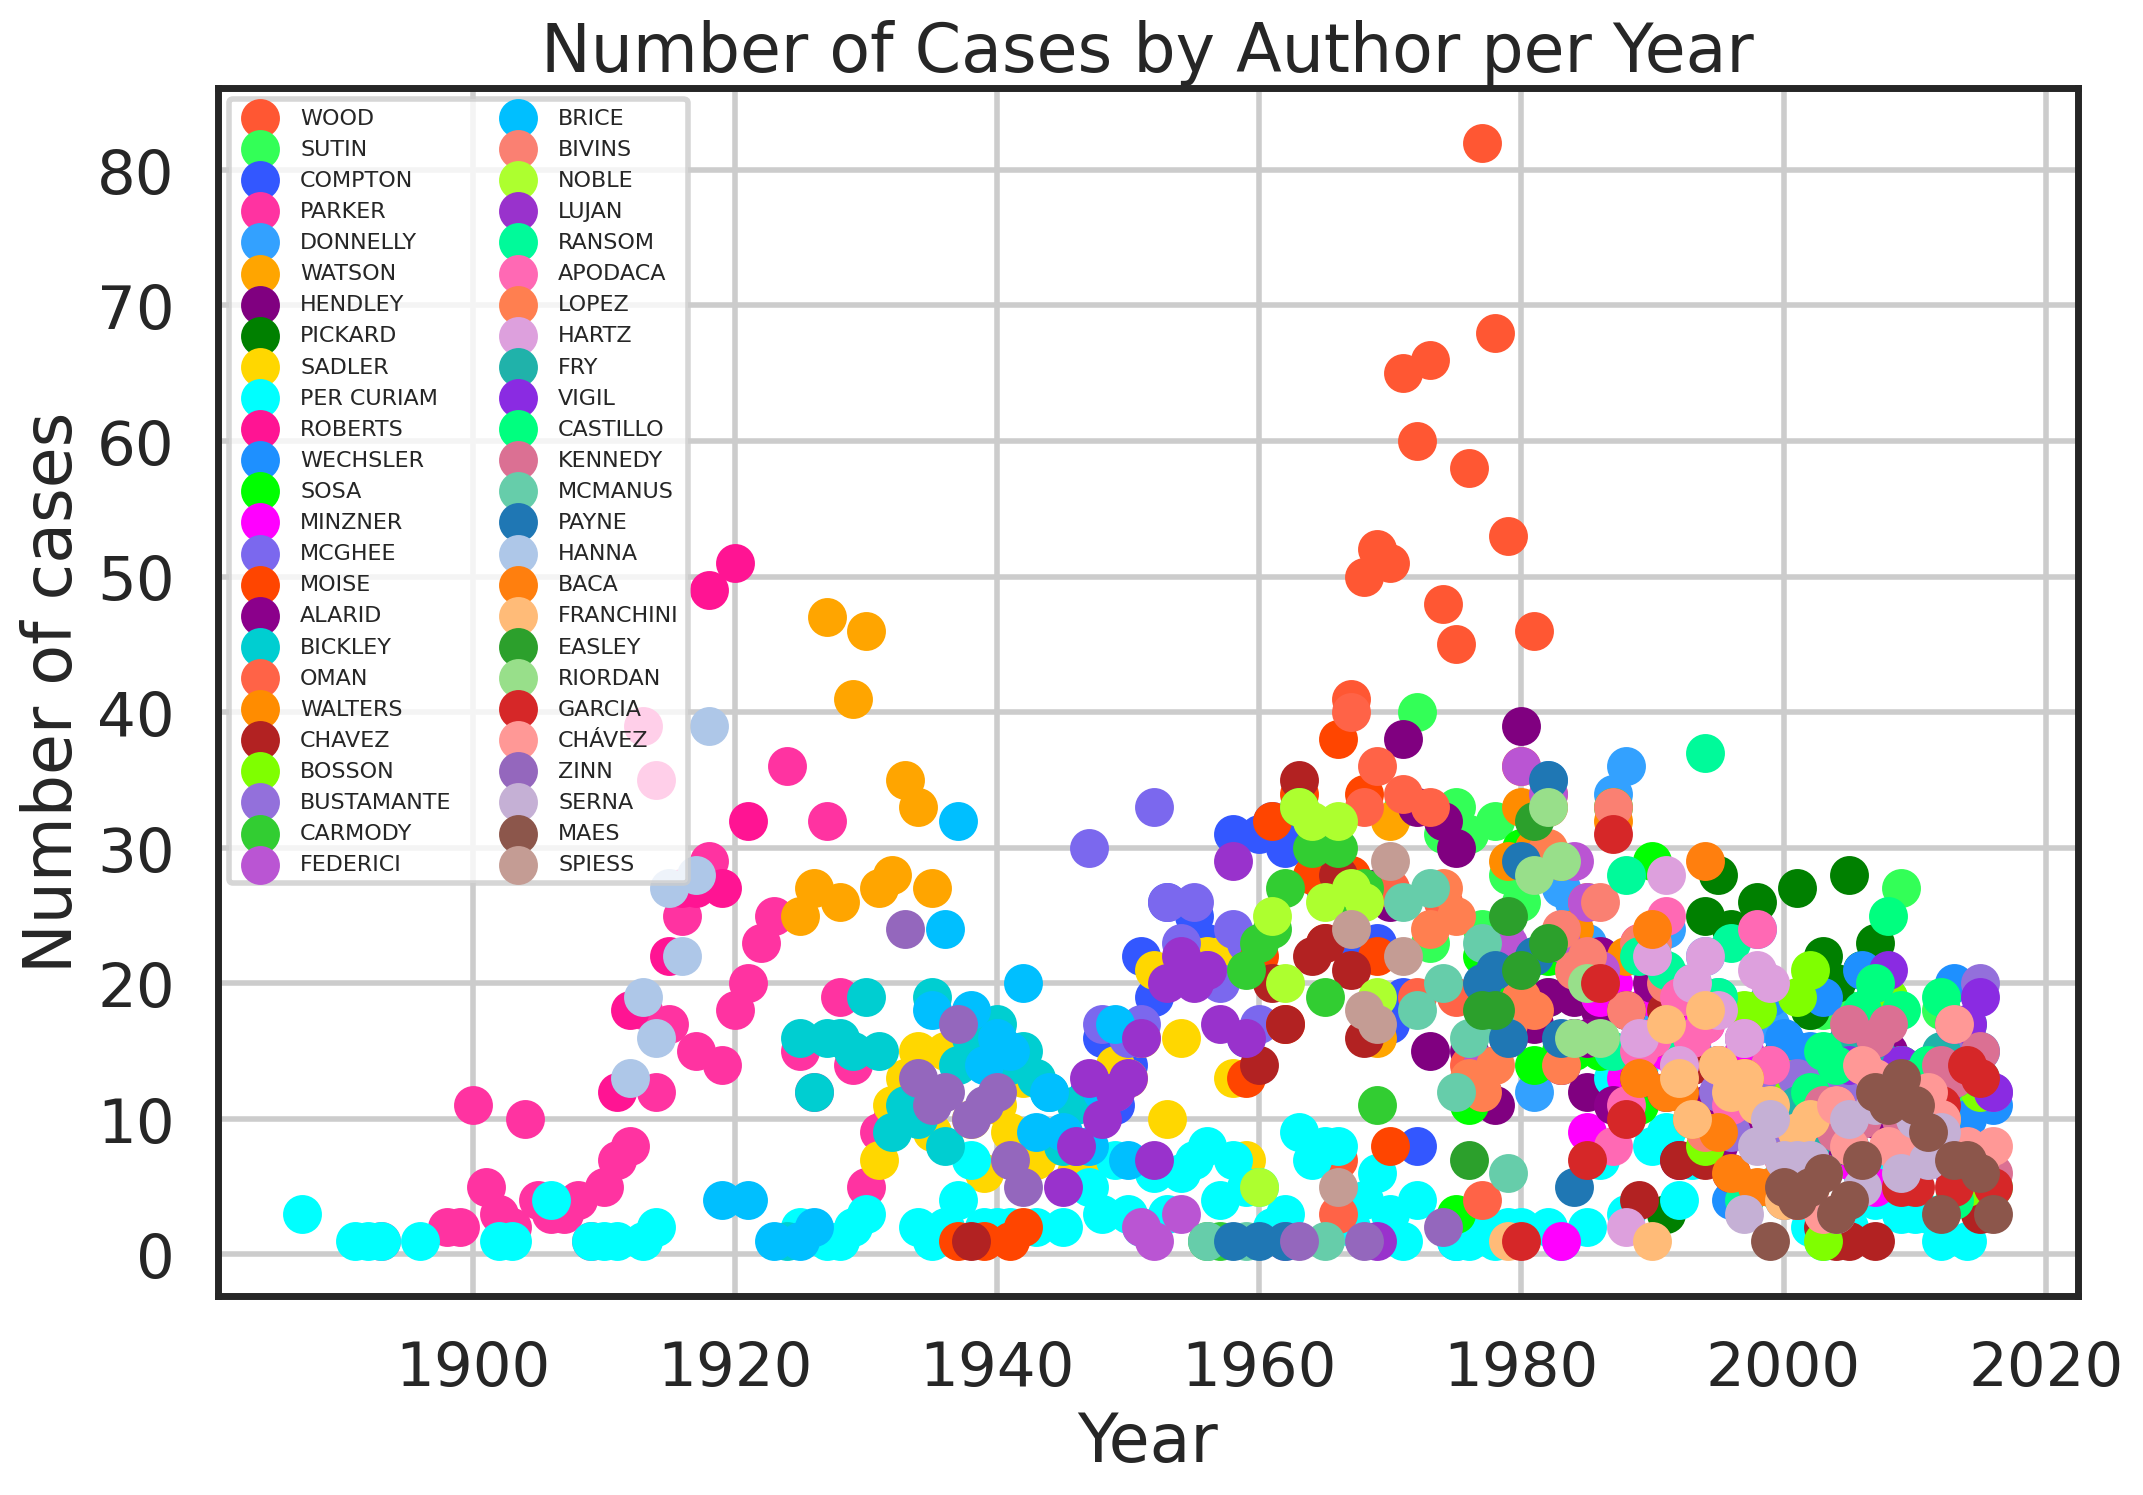

In [48]:
top_authors = sorted(authors_cases_dict.items(), key=lambda x: len(x[1]), reverse=True)[:50]
data_per_year = {}
for author, cases in authors_cases_dict.items():
    years, _ = zip(*cases)
    years_count = pd.Series(years).value_counts().sort_index()
    data_per_year[author] = years_count

df_per_year = pd.DataFrame(data_per_year)
selected_authors = [author for author, _ in top_authors]
df_selected = df_per_year[selected_authors]

additional_colors = [
    '#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#33A1FF',
    '#FFA500', '#800080', '#008000', '#FFD700', '#00FFFF',
    '#FF1493', '#1E90FF', '#00FF00', '#FF00FF', '#7B68EE',
    '#FF4500', '#8B008B', '#00CED1', '#FF6347', '#FF8C00',
    '#B22222', '#7FFF00', '#9370DB', '#32CD32', '#BA55D3',
    '#00BFFF', '#FA8072', '#ADFF2F', '#9932CC', '#00FA9A',
    '#FF69B4', '#1E90FF', '#FF7F50', '#DDA0DD', '#20B2AA',
    '#FF8C00', '#8A2BE2', '#00FF7F', '#DB7093', '#66CDAA'
    # Add more colors if needed
]

num_colors = len(selected_authors) + len(additional_colors)
palette = sns.color_palette(additional_colors + sns.color_palette("tab20", len(selected_authors)), n_colors=num_colors)

# Check to make sure judges have unique colors
author_to_color = {}  

# Scatter plot con colori diversi per i giudici
plt.figure(figsize=(12, 8), dpi=200)
for i, author in enumerate(df_selected.columns):
    color = palette[i]
    while color in author_to_color.values():
        i += 1
        color = palette[i]

    author_to_color[author] = color
    plt.scatter(df_selected.index, df_selected[author], label=author, color=color)

plt.title("Number of Cases by Author per Year")
plt.xlabel("Year")
plt.ylabel("Number of cases")
plt.legend(ncol=2, fontsize=8, frameon=True)
plt.grid(True)
plt.show()

In [52]:
# Single-element clusters, normalizing problem
count = 0
for author, case_ids in authors_cases_dict.items():
    num_cases = len(case_ids)
    if num_cases == 1:  # Only print if the cluster has more than one case
        print(f"Number of Cases: {num_cases}")
        print(f"Author: {author}")
        print(f"Case IDs: {case_ids}")
        print()
        count = count + 1
        if count == 3:
         break

Number of Cases: 1
Author: OPINION FRANCHINI
Case IDs: [(1998, 834344)]

Number of Cases: 1
Author: WRIGIIT
Case IDs: [(1910, 206008)]

Number of Cases: 1
Author: M'CFIE
Case IDs: [(1902, 11271939)]



# Let's try to normalize

In [50]:

ignore_initials = set(["J", "CJ", "JJ", "Justice", "Chief Justice", "Judge", "THOMAS", "GENE", "BENJAMIN", "ANTHONY", "LINDA", "ROBERT", "CONCUR", "PAMELA", "PAUL",
                       "CYNTHIA", "IRA", "RODERICK", "PATRICIO", "JOSEPH", "CELIA", "PETRA", "JIMENEZ", "RICHARD", "EDWARD", "GERALD", "JAMES", "CHARLES",
                       "BARBARA", "DANIELS", "MICHAEL", "EDWARD"
                         ])

name_mapping = {
    "mcmanus": "McManus",
    "mc-manus": "McManus",
    "manus": "McManus",
    "McMANUS": "McManus"
  
}

def is_judge_name(name):
    # Remove initials separated by semicolons and those to be ignored.
    normalized_name = re.sub(r"[.,]", "", name).strip()
    # Count the number of uppercase and lowercase letters in the word
    uppercase_count = sum(1 for c in normalized_name if c.isupper())
    lowercase_count = sum(1 for c in normalized_name if c.islower())
    return len(normalized_name) >= 3 and normalized_name not in ignore_initials and uppercase_count > lowercase_count

def normalize_judges_names(judges_text):
    # Split the string into individual tokens
    words = re.findall(r'\b\w+\b', judges_text) 
    judge_names = []
    seen_judges = set()  # Set to keep track of seen judges, must be added once
    for word in words:
        # Check if the word is "McManus" and treat it as a valid judge
        if word == "McMANUS":
            judge_names.append(word)
        else:
            # Check if the word is a judge name and get the standardized name from the mapping if it exists
            normalized_name = name_mapping.get(word.lower(), word)
            if is_judge_name(normalized_name) and normalized_name not in seen_judges:
                judge_names.append(normalized_name)
                seen_judges.add(normalized_name)

    output = " and ".join(judge_names)
    # Replace any consecutive sequences of "and" with one
    output = re.sub(r'\b(?:and\s*)+\b', ' and ', output)


    print(f"Input: {judges_text}, Result: {output}")
    return output

In [51]:
raw_df["author"] = raw_df["author"].astype(str)
raw_df["normalized_judge_names"] = raw_df["author"].apply(normalize_judges_names)
print(raw_df[["author", "case_id", "normalized_judge_names"]])


Input: MINZNER, Justice., Result: MINZNER
Input: WECHSLER, Judge., Result: WECHSLER
Input: PICKARD, Judge., Result: PICKARD
Input: BOSSON, Judge., Result: BOSSON
Input: PICKARD, Judge., Result: PICKARD
Input: BUSTAMANTE, Judge., Result: BUSTAMANTE
Input: WECHSLER, Judge., Result: WECHSLER
Input: BOSSON, Judge., Result: BOSSON
Input: ALARID, Judge., Result: ALARID
Input: FRANCHINI, Chief Justice., Result: FRANCHINI
Input: FRANCHINI, Chief Justice., Result: FRANCHINI
Input: MINZNER, Justice., Result: MINZNER
Input: APODACA, Judge., Result: APODACA
Input: BOSSON, Judge., Result: BOSSON
Input: PER CURIAM., Result: PER  and CURIAM
Input: DONNELLY, Judge., Result: DONNELLY
Input: PICKARD, Judge., Result: PICKARD
Input: RANSOM, Justice., Result: RANSOM
Input: ARMIJO, Judge., Result: ARMIJO
Input: WECHSLER, Judge., Result: WECHSLER
Input: BOSSON, Judge., Result: BOSSON
Input: WECHSLER, Judge., Result: WECHSLER
Input: WECHSLER, Judge., Result: WECHSLER
Input: FLORES, Judge., Result: FLORES
Inpu